# Exploratory data analysis - API FOURSQUARE

### Enviroment


In [1]:
import requests
import pandas as pd
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from rapidfuzz import process

ModuleNotFoundError: No module named 'seaborn'

### Data Collection Using Foursquare API V3

This script collects and exports detailed information about places in New York City boroughs using the Foursquare API V3.


In [ ]:
API_KEY = 'fsq3BQoHbBbTVjdTzDdZbyi3W4LGlfWu9OFlm3Xi4QtITS0='
BASE_URL = 'https://api.foursquare.com/v3/places'

headers = {
    "Accept": "application/json",
    "Authorization": API_KEY
}

OUTPUT_DIR = 'data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_ny_places_v3(location, categories=None, limit=50):
    params = {
        'near': location,
        'limit': limit
    }
    
    if categories:
        params['categories'] = categories
    
    try:
        response = requests.get(f"{BASE_URL}/search", headers=headers, params=params)
        response.raise_for_status()
        return response.json().get('results', [])
    except Exception as e:
        print(f"Error buscando lugares en {location}: {e}")
        return []
    
def get_place_details_v3(fsq_id):
    try:
        response = requests.get(f"{BASE_URL}/{fsq_id}", headers=headers)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error obteniendo detalles para {fsq_id}: {e}")
        return None

def collect_ny_data():

    categories = {
        'arts': 10000,  # Arts & Entertainment
        'food': 13000,  # Food
        'nightlife': 13003,  # Nightlife
        'outdoors': 16000,  # Outdoors & Recreation
        'shops': 17000  # Shops & Services
    }
    
    boroughs = [
        'Manhattan, NY',
        'Brooklyn, NY',
        'Queens, NY',
        'Bronx, NY',
        'Staten Island, NY'
    ]
    
    all_places = []
    
    for borough in boroughs:
        print(f"\nObteniendo datos para {borough}...")
        
      
        places = get_ny_places_v3(borough, limit=50)
        print(f"Encontrados {len(places)} lugares iniciales")
        
        for cat_name, cat_id in categories.items():
            cat_places = get_ny_places_v3(borough, categories=cat_id, limit=20)
            print(f" - {len(cat_places)} lugares en categoría {cat_name}")
            places.extend(cat_places)
            time.sleep(1) 

        for place in places:
            details = get_place_details_v3(place['fsq_id'])
            if details:
                all_places.append({
                    'id': details.get('fsq_id'),
                    'name': details.get('name'),
                    'latitude': details.get('geocodes', {}).get('main', {}).get('latitude'),
                    'longitude': details.get('geocodes', {}).get('main', {}).get('longitude'),
                    'category': details.get('categories', [{}])[0].get('name'),
                    'address': ', '.join(details.get('location', {}).get('formatted_address', [])),
                    'borough': borough.split(',')[0],
                    'price': details.get('price'),
                    'rating': details.get('rating'),
                    'hours': details.get('hours', {}).get('display'),
                    'popularity': details.get('popularity'),
                    'website': details.get('website'),
                    'phone': details.get('tel')
                })
            time.sleep(0.5) 
    
    return pd.DataFrame(all_places)


print("Iniciando extracción de datos con Foursquare V3 API...")
ny_places_df = collect_ny_data()

csv_path = os.path.join(OUTPUT_DIR, 'ny_places_foursquare_v3.csv')
ny_places_df.to_csv(csv_path, index=False, encoding='utf-8')

print(f"\nExtracción completada! Total de lugares obtenidos: {len(ny_places_df)}")
print(f"Datos guardados en: {os.path.abspath(csv_path)}")

if not ny_places_df.empty:
    print("\nVista previa de los datos:")
    print(ny_places_df.head())
else:
    print("\nNo se encontraron datos. Verifica tu API key y conexión.")

Iniciando extracción de datos con Foursquare V3 API...

Obteniendo datos para Manhattan, NY...
Encontrados 40 lugares iniciales
 - 20 lugares en categoría arts
 - 20 lugares en categoría food
 - 20 lugares en categoría nightlife
 - 20 lugares en categoría outdoors
 - 20 lugares en categoría shops

Obteniendo datos para Brooklyn, NY...
Encontrados 42 lugares iniciales
 - 20 lugares en categoría arts
 - 20 lugares en categoría food
 - 20 lugares en categoría nightlife
 - 20 lugares en categoría outdoors
 - 20 lugares en categoría shops

Obteniendo datos para Queens, NY...
Encontrados 29 lugares iniciales
 - 20 lugares en categoría arts
 - 20 lugares en categoría food
 - 20 lugares en categoría nightlife
 - 20 lugares en categoría outdoors
 - 20 lugares en categoría shops

Obteniendo datos para Bronx, NY...
Encontrados 18 lugares iniciales
 - 20 lugares en categoría arts
 - 20 lugares en categoría food
 - 20 lugares en categoría nightlife
 - 20 lugares en categoría outdoors
 - 20 lugares 

### Data Normalization and Cleaning

This code reads the dataset, normalizes the `category` column by matching it to a set of standard categories using fuzzy matching, and cleans the `address` column by removing commas. The first few rows of the cleaned dataframe are displayed using `df.head()`.


In [1]:
df = pd.read_csv("data/ny_places_foursquare_v3.csv")
categories = df['category'].unique()
standard_categories = ['Restaurant', 'Bar', 'Shopping Center', 'Cultural Place', 'Park']
normalization_dict = {}
for category in categories:
    match = process.extractOne(category, standard_categories)
    normalization_dict[category] = match[0]
df['category'] = df['category'].replace(normalization_dict)
df['address'] = df['address'].apply(lambda x: ''.join(x.split(', ')) if isinstance(df['address'].iloc[0], str) else df['address'])
df.head()

NameError: name 'pd' is not defined


### Dataset Structure Overview

The `df.info()` method provides a concise summary of the dataframe, including the number of non-null entries, data types of each column, and memory usage. This is useful for understanding the structure of the dataset and identifying columns with missing values or unexpected data types.


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          644 non-null    object 
 1   name        644 non-null    object 
 2   latitude    644 non-null    float64
 3   longitude   644 non-null    float64
 4   category    644 non-null    object 
 5   address     644 non-null    object 
 6   borough     644 non-null    object 
 7   price       0 non-null      float64
 8   rating      0 non-null      float64
 9   hours       0 non-null      float64
 10  popularity  0 non-null      float64
 11  website     0 non-null      float64
 12  phone       0 non-null      float64
dtypes: float64(8), object(5)
memory usage: 65.5+ KB



### Dataset Summary Statistics

The dataset contains 644 entries with valid `latitude` and `longitude` values, while other columns (`price`, `rating`, `hours`, `popularity`, `website`, `phone`) have no data available.

In [40]:
df.describe(include="all")

,id,name,latitude,longitude,category,address,borough,price,rating,hours,popularity,website,phone
count,644,644,644.000000,644.000000,644,644,644,0.0,0.0,0.0,0.0,0.0,0.0
unique,529,494,NaN,NaN,132,514,5,NaN,NaN,NaN,NaN,NaN,NaN
top,43222200f964a5209c271fe3,Trader Joe's,NaN,NaN,Park,"2, 6, 5, 5, , R, i, c, h, m, o, n, d, , A, v...",Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,8,NaN,NaN,45,6,142,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.724809,-73.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.089590,0.099037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,40.503139,-74.253253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,40.672103,-73.991019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,40.735916,-73.966246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,40.775975,-73.901682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### Checking for Missing Values

The code `df.isnull().sum()` is used to identify the number of missing (null) values in each column of the dataframe. This helps in understanding the completeness of the dataset and determining if any data cleaning steps are required.
- The dataset summary statistics show that the `latitude` and `longitude` columns have valid numerical data, while other columns (`price`, `rating`, `hours`, `popularity`, `website`, `phone`) contain only missing values (`NaN`). This indicates that location data is complete, but additional attributes are unavailable or not collected.

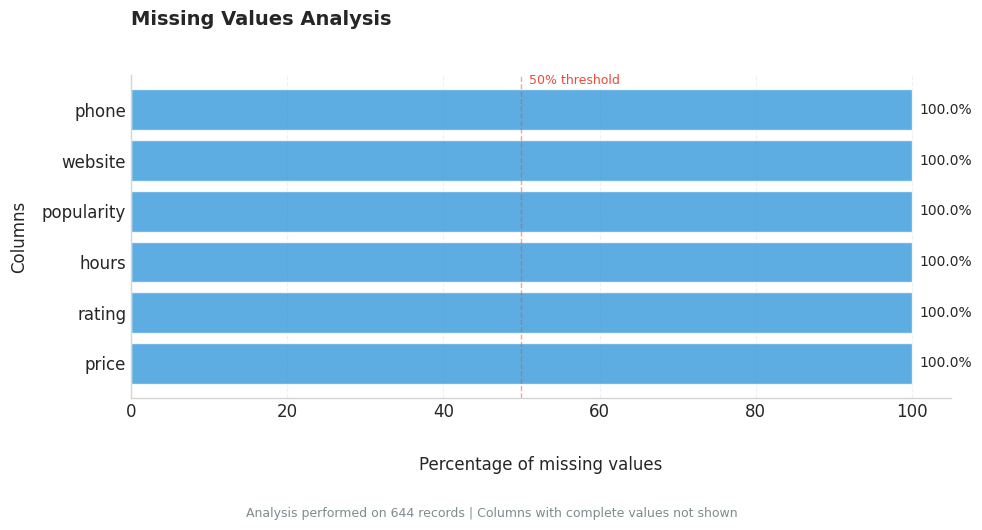

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
plt.rcParams['font.family'] = 'DejaVu Sans'

null_values = df.isnull().mean() * 100
null_values = null_values[null_values > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.barh(null_values.index, null_values.values, 
               color='#3498db', edgecolor='white', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%',
            va='center', ha='left', fontsize=10)

ax.axvline(x=50, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=1)
ax.text(51, len(null_values)-0.5, '50% threshold', 
        color='#e74c3c', fontsize=9)

ax.set_title('Missing Values Analysis\n', 
             fontsize=14, fontweight='bold', pad=20, loc='left')
ax.set_xlabel('\nPercentage of missing values', fontsize=12, labelpad=10)
ax.set_ylabel('Columns', fontsize=12, labelpad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d5d5d5')
ax.spines['bottom'].set_color('#d5d5d5')

ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.yaxis.grid(False)

fig.text(0.5, -0.05, 
         f'Analysis performed on {len(df)} records | Columns with complete values not shown', 
         ha='center', fontsize=9, color='#7f8c8d')

plt.tight_layout()

plt.show()


### Geographical Distribution of Places

This scatter plot visualizes the geographical distribution of places based on their longitude and latitude. Each point represents a location, color-coded by borough for better distinction. The plot provides insights into the spatial clustering of places across different boroughs.


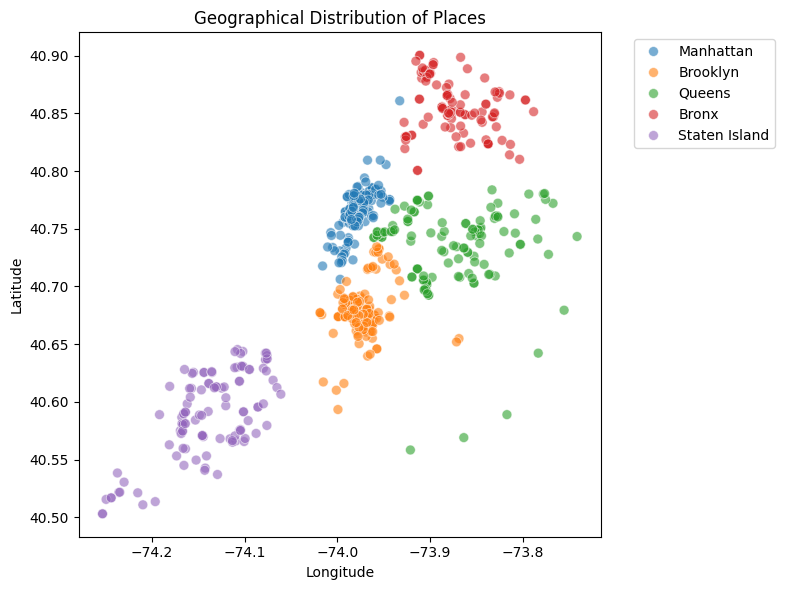

In [107]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='borough', alpha=0.6, s=50)
plt.title('Geographical Distribution of Places')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Interactive Map with Heatmap and Markers

This code generates an interactive map using the Folium library. It includes a heatmap to visualize the density of places based on their geographical coordinates and circle markers to represent individual locations. Each marker displays additional information, such as name, category, and address, in a popup. Boroughs are color-coded for better visualization, and a minimap is added for navigation. The map is saved as an HTML file and displayed in the notebook.

In [ ]:

map_center = [df['latitude'].mean(), df['longitude'].mean()]

m = folium.Map(location=map_center, 
               zoom_start=12, 
               tiles='cartodbpositron')

heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data, 
        radius=15, 
        blur=10, 
        max_zoom=13).add_to(m)

borough_colors = {
    'Manhattan': 'red',
    'Brooklyn': 'blue',
    'Queens': 'green',
    'Bronx': 'purple',
    'Staten Island': 'orange'
}

for idx, row in df.iterrows():
    popup_text = f"""
    <b>Nombre:</b> {row['name']}<br>
    <b>Categoría:</b> {row['category']}<br>
    <b>Dirección:</b> {row['address']}<br>
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=popup_text,
        color=borough_colors.get(row['borough'], 'gray'),
        fill=True,
        fill_color=borough_colors.get(row['borough'], 'gray'),
        fill_opacity=0.7
    ).add_to(m)

folium.LayerControl().add_to(m)

minimap = folium.plugins.MiniMap()
m.add_child(minimap)

m.save('ny_heatmap.html')  # Guardar para compartir
display(m)  # Mostrar en Jupyter Notebook

### Distribution of Places by Borough

Bar chart showing the number of places in each borough using `value_counts()` and `plot(kind='bar')`.

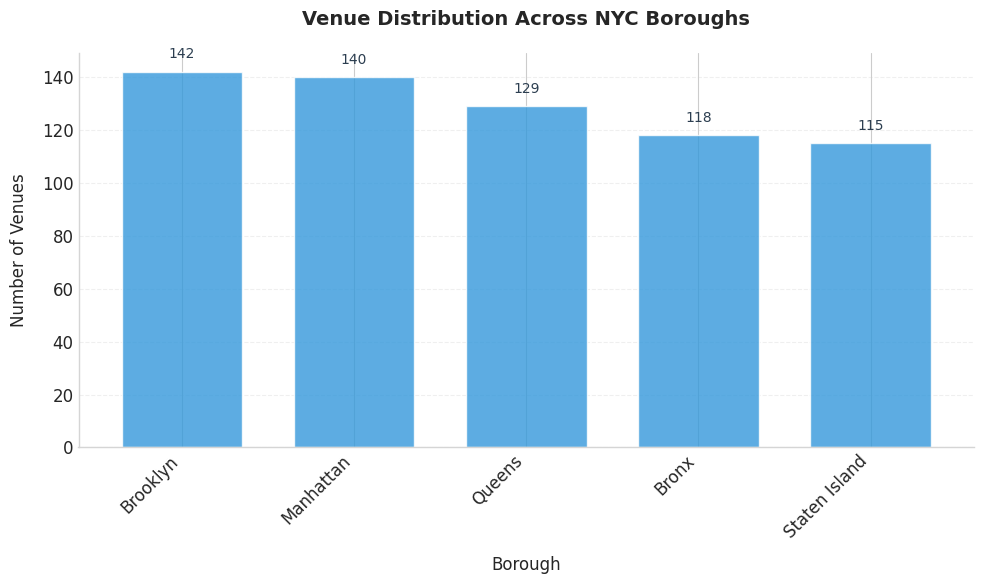

In [157]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlepad'] = 20

plt.figure(figsize=(10, 6))

borough_counts = df['borough'].value_counts()

ax = borough_counts.plot(kind='bar', 
                        color='#3498db', 
                        edgecolor='white',
                        alpha=0.8,
                        width=0.7)

for i, v in enumerate(borough_counts):
    ax.text(i, v + 5, str(v), 
            color='#2c3e50', 
            ha='center', 
            fontsize=10)

plt.title('Venue Distribution Across NYC Boroughs', 
          fontsize=14, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Borough', fontsize=12, labelpad=10)
plt.ylabel('Number of Venues', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right')  # Diagonal labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d5d5d5')
ax.spines['bottom'].set_color('#d5d5d5')

plt.tight_layout()

plt.show()


### Top 5 Most Common Categories

This horizontal bar chart visualizes the top 5 most common categories of places, displaying the number of places for each category. The chart includes value labels for better readability and uses a clean, professional style.


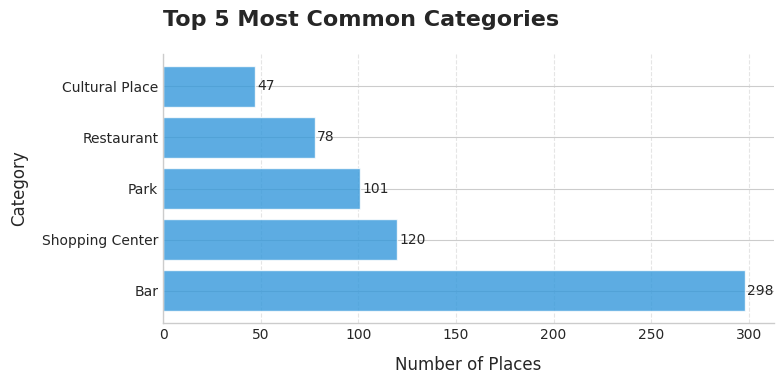

In [153]:
plt.figure(figsize=(8, 4))

top_categories = df['category'].value_counts().head(10)
bars = plt.barh(top_categories.index, top_categories.values, color='#3498db', edgecolor='white', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width}', 
             va='center', ha='left', fontsize=10)

plt.title('Top 5 Most Common Categories', fontsize=16, fontweight='bold', pad=20, loc='left')
plt.xlabel('Number of Places', fontsize=12, labelpad=10)
plt.ylabel('Category', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


### Category Distribution by Borough

This code generates a heatmap to visualize the distribution of categories across different boroughs. The heatmap is created using a cross-tabulation of the `borough` and `category` columns, with the `sns.heatmap()` function from the Seaborn library. The heatmap provides an intuitive way to identify patterns and relationships between boroughs and categories.

ValueError: 'cenx   er' is not a valid value for align; supported values are 'center', 'right', 'left'

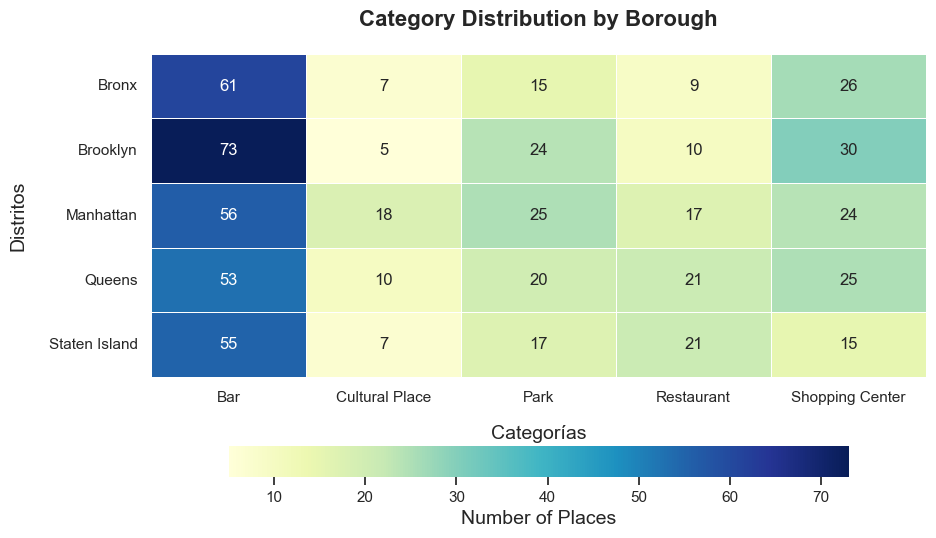

In [ ]:
df['category'] = df['category'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

cross_tab = pd.pivot_table(df, values='id', index='borough', columns='category', aggfunc='count', fill_value=0)

plt.style.use('default')
sns.set_theme(style="whitegrid")

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#f0f0f0'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

plt.figure(figsize=(10, 6))

custom_palette = sns.color_palette("YlGnBu", as_cmap=True)

ax = sns.heatmap(
    cross_tab,
    cmap=custom_palette,
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={
        'label': 'Number of Places', 
        'shrink': 0.8,
        'orientation': 'horizontal'
    },
    annot_kws={'size': 12}
)

plt.title('Category Distribution by Borough', 
          pad=20, fontsize=16, fontweight='bold')

ax.set_xlabel('Categorías', labelpad=15)
ax.set_ylabel('Distritos', labelpad=15)

# Corrección de alineación
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

cbar = ax.collections[0].colorbar
cbar.set_label('Cantidad', rotation=0, labelpad=10, y=0.5)

plt.tight_layout()
plt.show()